In [3]:
# Imports
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../../lib/python')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_merge_srr')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../../sra.h5', mode='r')

last updated: 2017-11-03 
Git hash: 45a2145854eb85cbbe473ad0738d4142c4df3dce


In [7]:
# Constants
from ncbi_remap.flagging import LIBSIZE_CUTOFF, READLEN_CUTOFF, STRAND_CUTOFF1, \
    STRAND_CUTOFF2, MAPPING_CUTOFF, CONTAMINATION_CUTOFF

# Merging SRXs

## Number of SRRs Per SRX

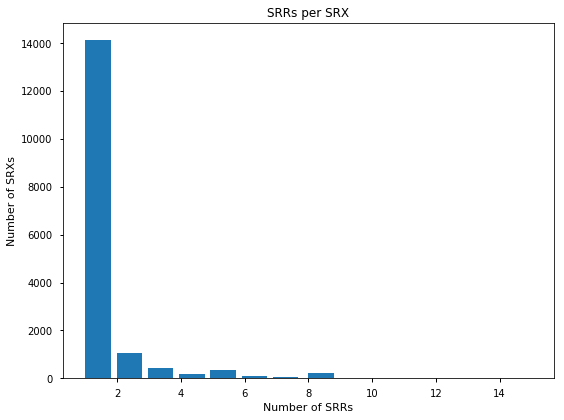

In [3]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('histogram_number_srr_per_srx'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/complete'].groupby('srx').count()
    fig, ax = plt.subplots(1, 1)
    df.hist(bins=100, width=.8, grid=False, ax=ax)
    ax.set_title('SRRs per SRX')
    ax.set_ylabel('Number of SRXs')
    ax.set_xlabel('Number of SRRs')
    return fig

plot(store)

In [4]:
# Make Flags
from ncbi_remap.flagging import srr_per_srx
srx_counts = srr_per_srx(store)
multi_srr_srx = srx_counts[(srx_counts > 1)['srr']].index.tolist()

print('There are {:,} SRXs that have more than 1 SRR.'.format(len(multi_srr_srx)))

There are 2,390 SRXs that have more than 1 SRR.


## Mapping similarity among SRX

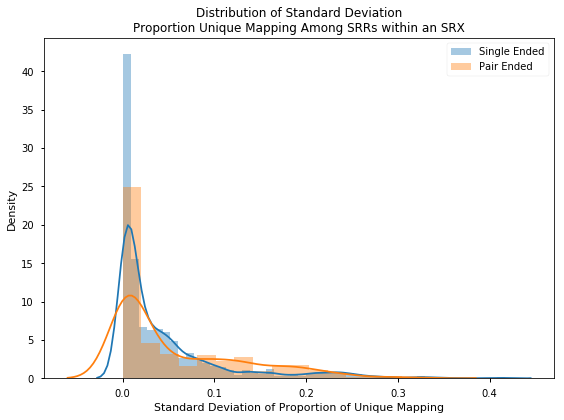

In [13]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('distplot_std_unique_mapping'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    from ncbi_remap.flagging import srr_per_srx
    srx_counts = srr_per_srx(store)
    multi_srr_srx = srx_counts[(srx_counts > 1)['srr']].index.tolist()

    se = store['prealn/workflow/hisat2/SE'][['srx', 'srr', 'num_reads', 'num_uniquely_aligned']]
    se['prop_unique_aligned'] = se['num_uniquely_aligned'] / se['num_reads']
    se = se[se.srx.isin(multi_srr_srx)]

    pe = store['prealn/workflow/hisat2/PE'][['srx', 'srr', 'num_reads', 'num_concordant_reads_uniquely_aligned']]
    pe['prop_unique_aligned'] = pe['num_concordant_reads_uniquely_aligned'] / pe['num_reads']
    pe = pe[pe.srx.isin(multi_srr_srx)]

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.groupby('srx')['prop_unique_aligned'].std(), ax=ax, label='Single Ended')
    sns.distplot(pe.groupby('srx')['prop_unique_aligned'].std(), ax=ax, label='Pair Ended')
    ax.legend()
    
    ax.set_title('Distribution of Standard Deviation\nProportion Unique Mapping Among SRRs within an SRX')
    ax.set_xlabel('Standard Deviation of Proportion of Unique Mapping')
    ax.set_ylabel('Density');
    
    return fig

plot(store)